# The Data Wizards - Text Analytics Group Project - Fake News

In [1]:
# Install the required packages
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns
import ssl

from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob
from tqdm import tqdm
from wordcloud import WordCloud

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dstmartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load, Clean, and Explore the Data

In [2]:
# Import the dataset
data = pd.read_csv('data/train.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
data.shape

(20800, 5)

In [4]:
# Drop the columns that are not needed
data = data.drop(['title'], axis=1)

In [5]:
# Check for missing values
data.isnull().sum()

id           0
author    1957
text        39
label        0
dtype: int64

In [6]:
# Replace null value in author with "Unknown"
data['author'] = data['author'].fillna('Unknown')

# Use a common value for unknown authors
data['author'] = data['author'].replace(
    ['-NO AUTHOR-', 'noreply@blogger.com (Alexander Light)', 'noreply@blogger.com (Der Postillon)', 'Dikran Arakelian (noreply@blogger.com)'], 
    ['Unknown', 'Alexander Light', 'Der Postillon', 'Dikran Arakelian'])

In [7]:
# Drop the rows with missing values
data = data.dropna()

In [8]:
# Shuffle the dataset and drop the index
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

In [9]:
data

,id,author,text,label
0,3528,"Alexander Burns, Jonathan Martin and Maggie Ha...",The Republican Party was at the brink of civil...,0
1,17290,Daniel Lewis,"Gene Wilder, who established himself as one of...",0
2,6361,Matthew Boyle,Politico is reporting late Sunday that White H...,0
3,10069,Jack Montgomery,European Union (EU) countries which constructe...,0
4,1106,Rebecca Diserio,BLM Rapper & Bill’s Alleged Son Have Nasty Sur...,1
...,...,...,...,...
20756,1939,Arnaldo Rodgers,‹ › Arnaldo Rodgers is a trained and educated ...,1
20757,12520,Dwight Garner,THE IDIOTBy Elif Batuman423 pages. Penguin Pre...,0
20758,9260,Eric Lichtblau,WASHINGTON — The Justice Department said Th...,0
20759,19207,Penny Starr,The photo of Kathy Griffin posing with the sev...,0


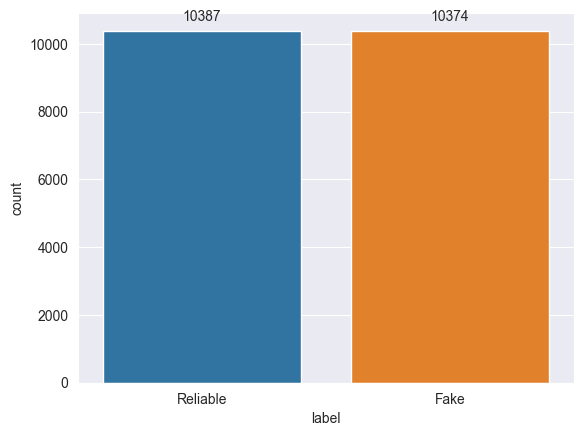

In [10]:
# Show the distribution of the labels
ax = sns.countplot(data=data, x='label', order=data['label'].value_counts().index, palette='tab10', hue='label', legend=False)

# Change x-axis labels to 'Fake' and 'Reliable'
ax.set_xticks([0,1])
ax.set_xticklabels(['Reliable', 'Fake'])

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



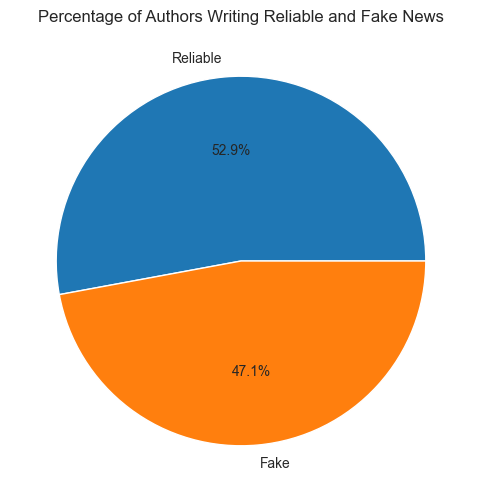

In [11]:
# Group the data by 'author' and 'label' and count the number of unique authors for each group
author_label_counts = data.groupby('label')['author'].nunique()

# Create a DataFrame that contains the number of authors for each label
author_counts = pd.DataFrame({'Label': ['Reliable', 'Fake'], 'Count': [author_label_counts[0], author_label_counts[1]]})

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(author_counts['Count'], labels=author_counts['Label'], autopct='%1.1f%%')
plt.title('Percentage of Authors Writing Reliable and Fake News')
plt.show()

In [12]:
# Preprocess the data given as input
def preprocess_data(text_data):
    corpus = []
    for sentence in tqdm(text_data):
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        corpus.append(' '.join(token.lower() for token in str(sentence).split() if token not in stopwords.words('english')))
    return corpus

In [13]:
preprocessed_reviews = preprocess_data(data['text'].values)
data['text'] = preprocessed_reviews

100%|██████████| 20761/20761 [28:26<00:00, 12.17it/s] 


## Visualize Words Used in Fake and Reliable News

In [14]:
# Function to create a word cloud
def create_word_cloud(corpus, label):
    consolidated = ' '.join(word for word in corpus['text'][corpus['label'] == label].astype(str))
    wordcloud = WordCloud(width=1600, height=800, max_words=200, random_state=21, background_color='white', max_font_size=110, collocations=False, colormap='cividis', min_word_length=3)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.generate(consolidated), interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [15]:
# Function to plot the top words
def plot_top_words(corpus, title, number=None):
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(corpus)
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

    # Exclude unhelpful words
    frequency = frequency[~frequency['word'].isin(['said', 'mr', 'ms'])]
           
    # Plot the data
    plt.figure(figsize=(15, 10))
    sns.barplot(x='word', y='freq', data=frequency.head(number), palette='tab10', hue='word', legend=False)
    plt.title(title)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation='vertical')
    plt.show()

### Question 1: Which words in an article are most likely to appear in fake news?

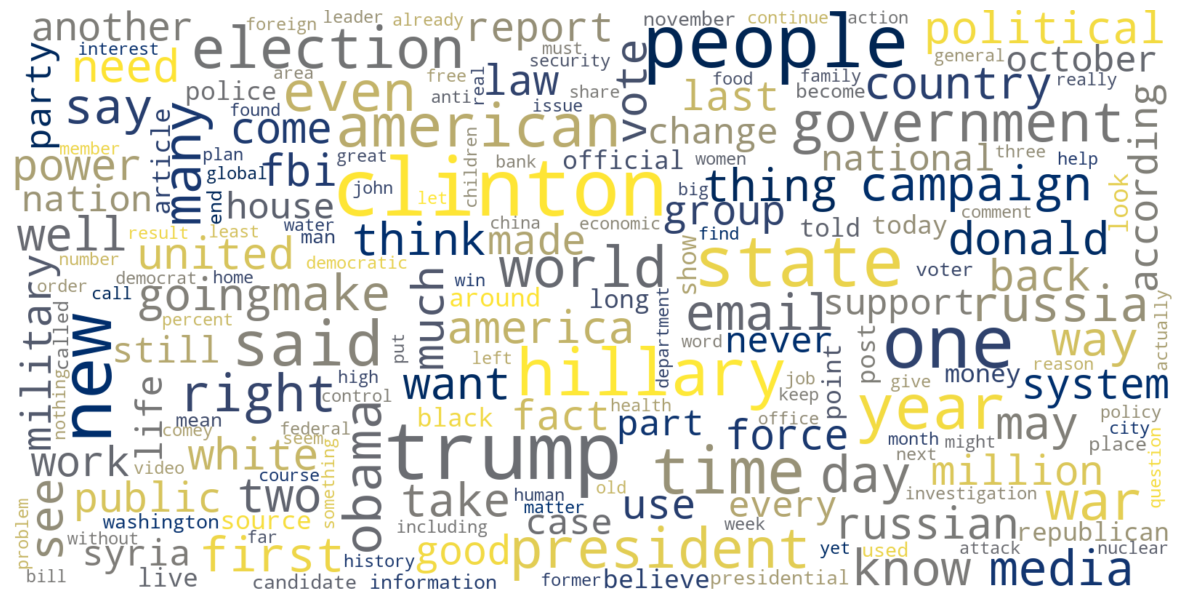

In [16]:
# Fake News
create_word_cloud(data, 1)

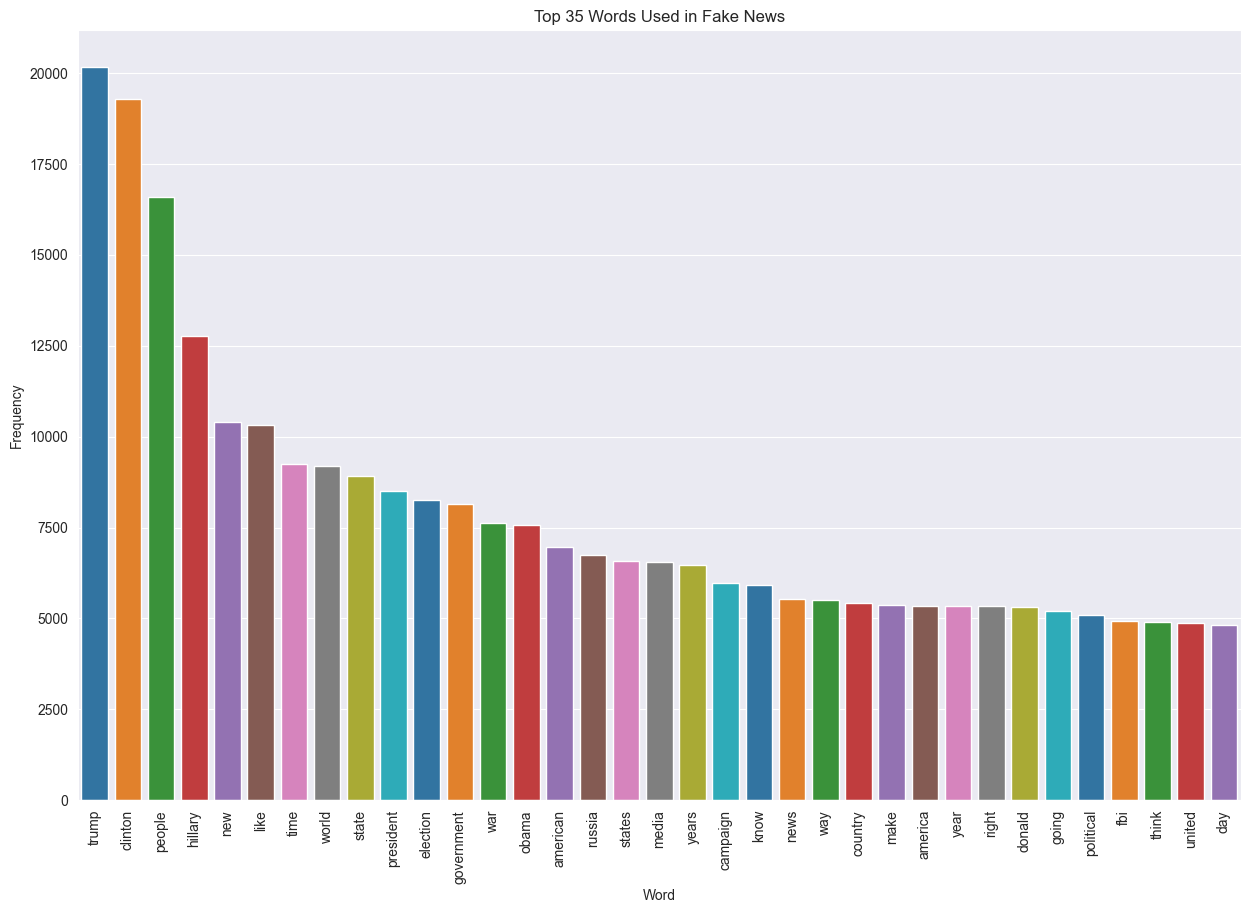

In [17]:
# Fake News
plot_top_words(data['text'][data['label'] == 1], 'Top 35 Words Used in Fake News', 35)


### Question 2: Which words in an article are most likely to appear in reliable news?

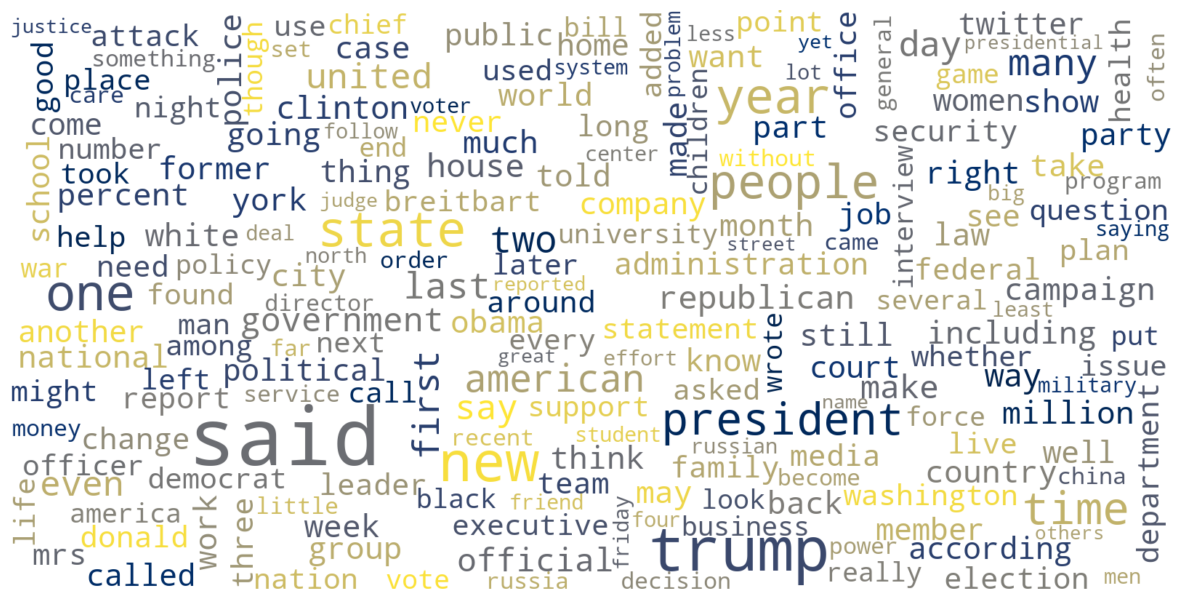

In [18]:
# Reliable news
create_word_cloud(data, 0)

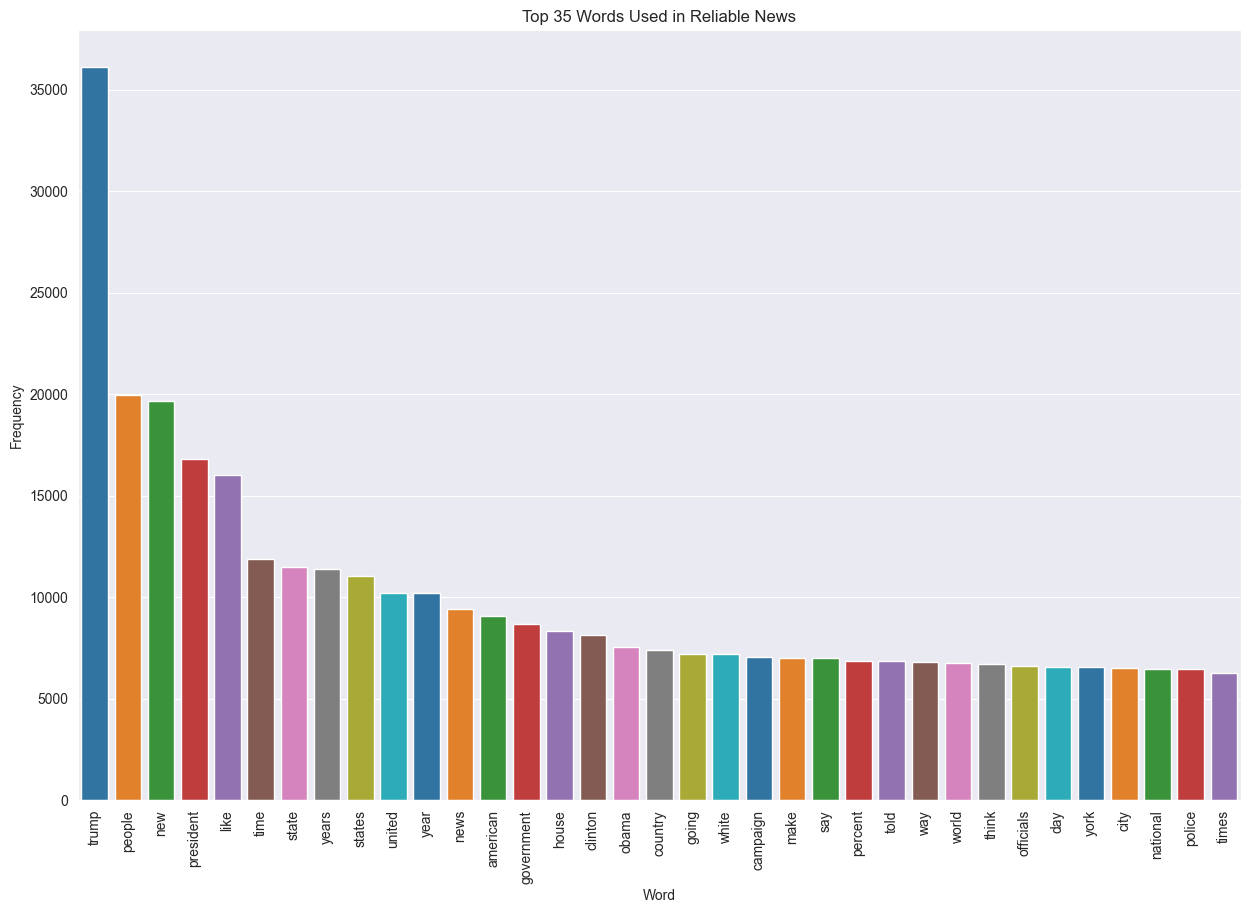

In [19]:
# Reliable News
plot_top_words(data['text'][data['label'] == 0], 'Top 35 Words Used in Reliable News', 35)

## Sentiment Analysis

In [20]:
data['sentiment'] = data['text'].map(lambda text: TextBlob(text).sentiment.polarity)
data.head()

,id,author,text,label,sentiment
0,3528,"Alexander Burns, Jonathan Martin and Maggie Ha...",the republican party brink civil war sunday do...,0,0.075779
1,17290,Daniel Lewis,gene wilder established one america foremost c...,0,0.088033
2,6361,Matthew Boyle,politico reporting late sunday white house chi...,0,0.061472
3,10069,Jack Montgomery,european union eu countries constructed border...,0,-0.067364
4,1106,Rebecca Diserio,blm rapper bill alleged son have nasty surpris...,1,-0.091071


### Question 3: What is the sentiment distribution of reliable news articles?

In [21]:
# Sentiment analysis on news headlines for reliable news (label = 0)

data['sentiment_reliable'] = data['text'][data['label'] == 0].map(lambda text: TextBlob(text).sentiment.polarity)
data.head()

,id,author,text,label,sentiment,sentiment_reliable
0,3528,"Alexander Burns, Jonathan Martin and Maggie Ha...",the republican party brink civil war sunday do...,0,0.075779,0.075779
1,17290,Daniel Lewis,gene wilder established one america foremost c...,0,0.088033,0.088033
2,6361,Matthew Boyle,politico reporting late sunday white house chi...,0,0.061472,0.061472
3,10069,Jack Montgomery,european union eu countries constructed border...,0,-0.067364,-0.067364
4,1106,Rebecca Diserio,blm rapper bill alleged son have nasty surpris...,1,-0.091071,NaN


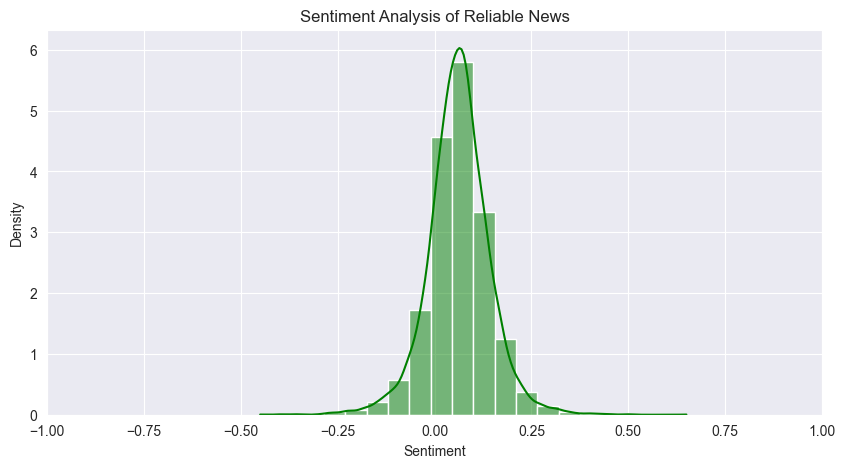

In [22]:
# Plot the sentiment analysis for reliable news
sns.histplot(data['sentiment'][data['label'] == 0], stat='density', bins=20, kde=True, color='green')
plt.gcf().set_size_inches(10, 5)
plt.title('Sentiment Analysis of Reliable News')
plt.xlabel('Sentiment')
plt.xlim(-1, 1)
plt.show()

### Question 4: What is the sentiment distribution of fake news articles?

In [23]:
# Sentiment analysis on news headlines for fake news (label = 1)

data['sentiment_fake'] = data['text'][data['label'] == 1].map(lambda text: TextBlob(text).sentiment.polarity)
data.head()

,id,author,text,label,sentiment,sentiment_reliable,sentiment_fake
0,3528,"Alexander Burns, Jonathan Martin and Maggie Ha...",the republican party brink civil war sunday do...,0,0.075779,0.075779,NaN
1,17290,Daniel Lewis,gene wilder established one america foremost c...,0,0.088033,0.088033,NaN
2,6361,Matthew Boyle,politico reporting late sunday white house chi...,0,0.061472,0.061472,NaN
3,10069,Jack Montgomery,european union eu countries constructed border...,0,-0.067364,-0.067364,NaN
4,1106,Rebecca Diserio,blm rapper bill alleged son have nasty surpris...,1,-0.091071,NaN,-0.091071


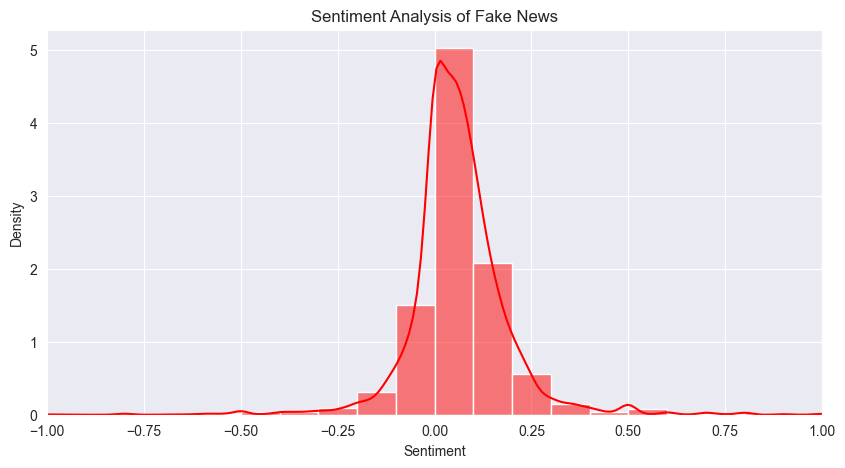

In [24]:
# Plot the sentiment analysis for fake news
sns.histplot(data['sentiment'][data['label'] == 1], stat='density', bins=20, kde=True, color='red')
plt.gcf().set_size_inches(10, 5)
plt.title('Sentiment Analysis of Fake News')
plt.xlabel('Sentiment')
plt.xlim(-1, 1)
plt.show()


### Question 5: How does the sentiment (positive, negative, neutral) differ in fake news versus reliable news?

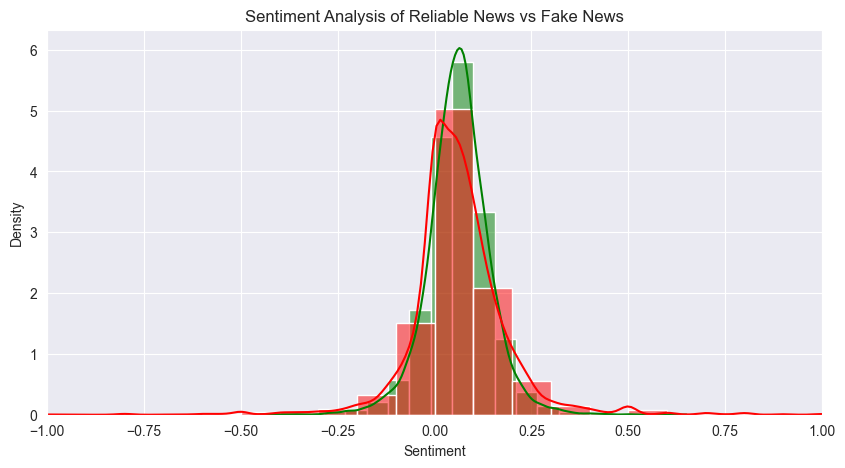

In [25]:
#Plot the sentiment analysis for the news headlines for label = 0 (reliable news)
sns.histplot(data['sentiment'][data['label'] == 0], stat='density', bins=20, kde=True, color='green')
sns.histplot(data['sentiment'][data['label'] == 1], stat='density', bins=20, kde=True, color='red')
plt.gcf().set_size_inches(10, 5)
plt.title('Sentiment Analysis of Reliable News vs Fake News')
plt.xlabel('Sentiment')
plt.xlim(-1, 1)
plt.show()

### Question 6: Who are the top 30 authors that publish fake news and, therefore, are less reliable? 

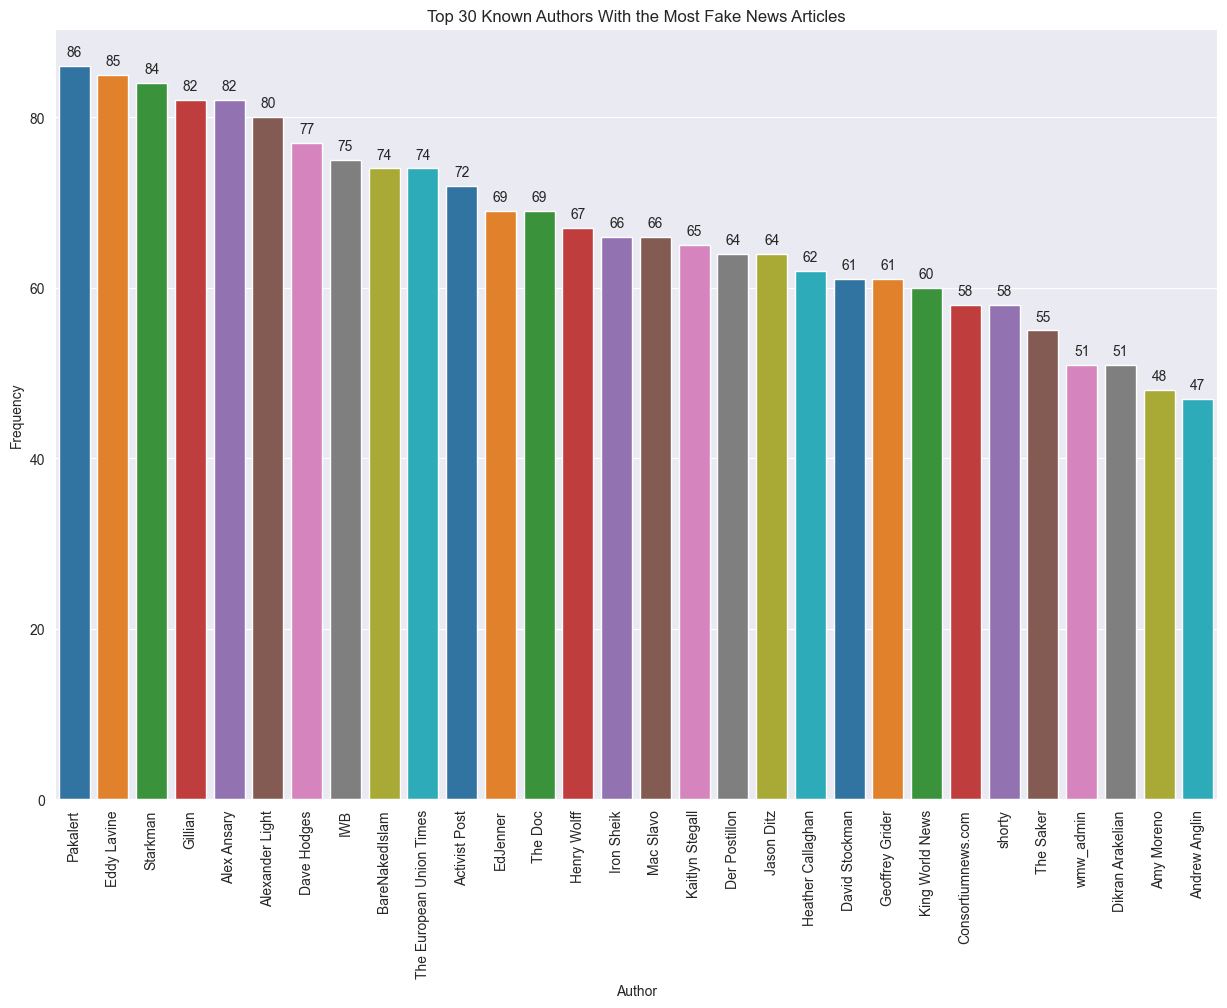

In [26]:
# Chart the top 30 authors with the most fake news articles
plt.figure(figsize=(15, 10))

filtered_data = data[~data['author'].isin(['Unknown', 'admin', 'Editor', 'Anonymous'])]

sns.barplot(x=filtered_data['author'][filtered_data['label'] == 1].value_counts().head(30).index,
            y=filtered_data['author'][filtered_data['label'] == 1].value_counts().head(30).values,
            palette='tab10', hue=filtered_data['author'][filtered_data['label'] == 1].value_counts().head(30).index)

# Annotate each bar with the count
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Top 30 Known Authors With the Most Fake News Articles')
plt.xlabel('Author')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.show()


/var/folders/09/8wlbz8dd26dfzjrwrpsmm7sw0000gp/T/ipykernel_1464/1374434291.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(plot_data.index[i], (plot_data['ReliabilityScore'][i], plot_data['FakeNewsCount'][i]), textcoords="offset points", xytext=(0,5), ha='center')


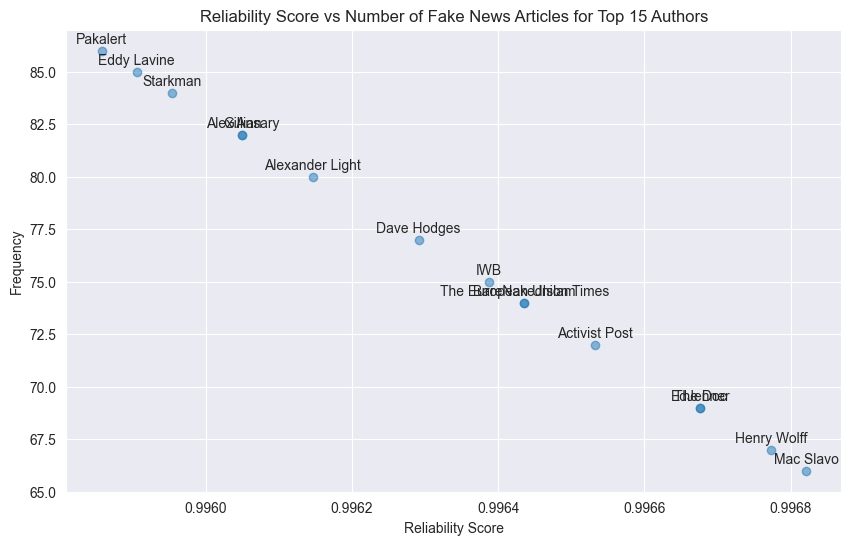

In [27]:
# Sort the data by the author's name in ascending order
data = data.sort_values(by='author')

# Filter admin and unknown authors
filtered_data = data[~data['author'].isin(['Unknown', 'admin', 'Editor', 'Anonymous'])]

# Calculate the number of fake news articles for each author
fake_news_count = filtered_data[filtered_data['label'] == 1]['author'].value_counts()

# Select the top 15 authors with the most fake news articles
top_authors = fake_news_count.nlargest(15).index

# Filter the data to include only the top authors
filtered_data = filtered_data[filtered_data['author'].isin(top_authors)]

# Calculate the total number of articles for each of these authors
total_articles_count = filtered_data['author'].value_counts()

# Calculate the total number of articles in the dataset
total_articles = len(data)

# Calculate the percentage of total articles for each author
percentage_of_total_articles = (total_articles_count / total_articles) * 100

# Calculate the reliability score for each of these authors
reliability_score = 1 - (fake_news_count.loc[top_authors] / total_articles)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'FakeNewsCount': fake_news_count.loc[top_authors],
    'TotalArticlesCount': total_articles_count,
    'ReliabilityScore': reliability_score,
    'PercentageOfTotalArticles': percentage_of_total_articles
})

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['ReliabilityScore'], plot_data['FakeNewsCount'], alpha=0.5)
plt.xlabel('Reliability Score')
plt.ylabel('Frequency')
plt.title('Reliability Score vs Number of Fake News Articles for Top 15 Authors')
for i in range(len(plot_data)):
    plt.annotate(plot_data.index[i], (plot_data['ReliabilityScore'][i], plot_data['FakeNewsCount'][i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.show()


## Convert Text Into Vectors

In [28]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data['text'],
                                                    data['label'],
                                                    test_size=0.25)


In [29]:
# Convert the training data into vectors using TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


## Train the Model

In [30]:
# Train the model using logistic regression
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [31]:
# Test the model
print(f'Accuracy: {accuracy_score(y_train, model.predict(x_train)) * 100:.2f}%')
print(f'Accuracy: {accuracy_score(y_test, model.predict(x_test)) * 100:.2f}%')

Accuracy: 97.47%
Accuracy: 95.20%


In [32]:
# Test with decision tree classifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# Test the model
print(f'Accuracy: {accuracy_score(y_train, model.predict(x_train)) * 100:.2f}%')
print(f'Accuracy: {accuracy_score(y_test, model.predict(x_test)) * 100:.2f}%')


Accuracy: 100.00%
Accuracy: 87.52%


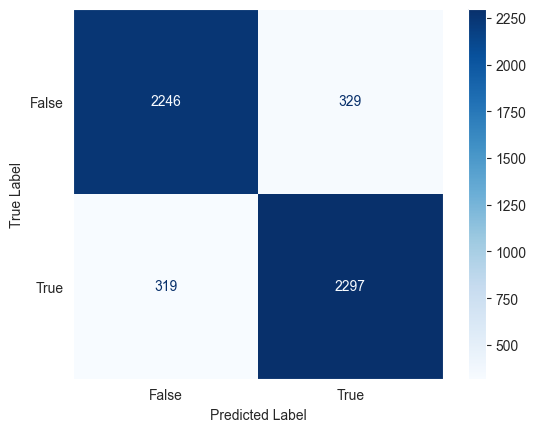

In [33]:
# Show confusion matrix of the results from the decision tree classification
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True]).plot(cmap='Blues')
plt.grid(False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()